<a href="https://colab.research.google.com/github/abhiyantaabhishek/SpamClassification/blob/master/spam_classification_using_elmo_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub
import pandas as pd
from sklearn import preprocessing
import keras
import numpy as np

1.15.2


Using TensorFlow backend.


In [1]:
!pip install kaggle

In [0]:
!mkdir -p /root/.kaggle/

Go to https://www.kaggle.com/Your_user_name/account to know kaggle api key


In [4]:
%%writefile /root/.kaggle/kaggle.json 
{"username":"Your User Name","key":"Your kaggle api key"}

Overwriting /root/.kaggle/kaggle.json


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

sms-spam-collection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
!unzip sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [8]:
ls

sample_data/


In [0]:
url = "https://tfhub.dev/google/elmo/2"
embed = hub.Module(url)

In [0]:
data = pd.read_csv('spam.csv', encoding='latin-1')

In [9]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [0]:
y = list(data['v1'])
x = list(data['v2'])

In [11]:
le = preprocessing.LabelEncoder()
le.fit(y)

LabelEncoder()

In [0]:
def encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)


In [0]:
test = encode(le, ['ham', 'spam', 'ham', 'ham'])

In [14]:
test

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [0]:
untest = decode(le, test)

In [16]:
untest

array(['ham', 'spam', 'ham', 'ham'], dtype='<U4')

In [0]:
x_enc = x
y_enc = encode(le, y)


In [0]:
x_train = np.asarray(x_enc[:5000])
y_train = np.asarray(y_enc[:5000])

x_test = np.asarray(x_enc[5000:])
y_test = np.asarray(y_enc[5000:])

In [0]:
import keras.backend as K
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [25]:

def ELMoEmbedding(input_text):
    return embed(tf.reshape(tf.cast(input_text, tf.string), [-1]), signature="default", as_dict=True)["elmo"]

input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
BiLSTM = Bidirectional(layers.LSTM(1024, return_sequences= False, recurrent_dropout=0.2, dropout=0.2), name="BiLSTM")(embedding)
dense = Dense(256, activation='relu')(BiLSTM)
pred = Dense(2, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda (Lambda)              (None, None, 1024)        0         
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 2048)              16785408  
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 17,310,466
Trainable params: 17,310,466
Non-trainable params: 0
_________________________________________________________________


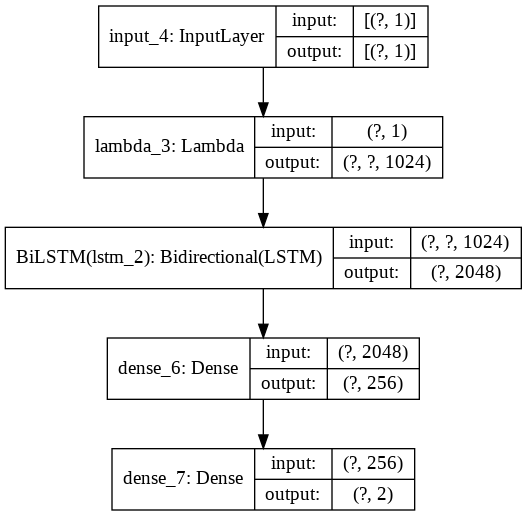

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, to_file='model.png')

In [47]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(x_train, y_train, epochs=1, batch_size=32)
    model.save_weights('./elmo-model.h5')

Train on 5000 samples
5000/5000 [==============================] - 204s 41ms/sample - loss: 0.0947 - acc: 0.9698


In [0]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./elmo-model.h5')  
    predicts = model.predict(x_test, batch_size=32)

In [0]:
y_test = decode(le, y_test)
y_preds = decode(le, predicts)

In [50]:
from sklearn import metrics

print(metrics.confusion_matrix(y_test, y_preds))

print(metrics.classification_report(y_test, y_preds))

[[495   3]
 [  4  70]]
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       498
        spam       0.96      0.95      0.95        74

    accuracy                           0.99       572
   macro avg       0.98      0.97      0.97       572
weighted avg       0.99      0.99      0.99       572

